# ** 2° Telecom X - Prevendo Churn**

### **Visão Geral**

O objetivo deste projeto é criar um sistema que prevê quais clientes da Telecom X podem cancelar seus serviços.

### **Etapas**

Para isso, vamos seguir um processo de seis etapas:

1.  **Preparar os dados:** organizar e limpar os dados para que os modelos possam usá-los.
2.  **Analisar as variáveis:** entender como as informações dos clientes se relacionam com o cancelamento e selecionar as mais importantes para a previsão.
3.  **Treinar os modelos:** testar diferentes modelos para ver qual deles é mais eficaz.
4.  **Avaliar os resultados:** verificar o desempenho dos modelos usando métricas de precisão.
5.  **Interpretar as variáveis:** entender por que cada modelo chegou a determinada conclusão.
6.  **Concluir:** identificar os principais motivos que levam os clientes a saírem da Telecom X.

### A meta é fornecer à Telecom X informações que ajudem a empresa a manter seus clientes, tomando decisões estratégicas antes que eles cancelem.

In [809]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

# Extração do Arquivo Tratado
O arquivo utilizado é o mesmo já tratado do Telecom X. Ele ja se encontra organizado após todos as etapas

In [810]:
df= pd.read_csv('/content/dados_trabalhado.csv')
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas.Diarias,Client_status
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667,Ativo
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667,Ativo
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333,Cancelado
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667,Cancelado
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667,Cancelado


In [811]:
# visualizar as informações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   int64  
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   int64  
 5   Dependents        7032 non-null   int64  
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   int64  
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 


# Remoção de Colunas Irrelevantes

## Colunas como ID do cliente não trazem valor para a análise ou para os modelos preditivos.

In [812]:
# remover a coluna de identificação de cliente "customerID"
df = df.drop(['customerID'], axis=1)

# Encoding
Transformar variáveis categóricas em formato numérico

In [813]:
# criar cópia de segurança do DataFrame, como garantia
df_Encoding = df.copy()

# Variáveis Categóricas

In [814]:
# Definir explicitamente os tipos de dados para evitar ambiguidades
columns_categoricas = df.select_dtypes(
    include=['object', 'category', 'bool', 'string']
).columns.tolist()

columns_numericas = df.select_dtypes(
    include=['int', 'int8', 'int16', 'int32', 'int64',
             'float', 'float16', 'float32', 'float64']
).columns.tolist()

In [815]:
# one-hot encoding nas colunas categóricas
df_Encoding = pd.get_dummies(df_Encoding, columns=columns_categoricas, drop_first=True, dtype=int)
df_Encoding.head()

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,Contas.Diarias,...,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Client_status_Cancelado
0,0,0,1,1,9,1,1,65.6,593.30,2.186667,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,9,1,0,59.9,542.40,1.996667,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,4,1,1,73.9,280.85,2.463333,...,0,0,0,0,0,0,0,1,0,1
3,1,1,1,0,13,1,1,98.0,1237.85,3.266667,...,1,0,1,0,0,0,0,1,0,1
4,1,1,1,0,3,1,1,83.9,267.40,2.796667,...,1,0,0,0,0,0,0,0,1,1


# Verificação da Proporção de Evasão
Calculo da proporção de clientes que evadiram em relação aos que permaneceram ativos

In [816]:
# Análise de distribuição do Churn
churn_counts = df_Encoding["Churn"].value_counts()
total = churn_counts.sum()
proporcoes = churn_counts / total

print(f"Distribuição do Churn (Total: {total:,})")
for i, (classe, count) in enumerate(churn_counts.items()):
    status = "ATIVOS" if classe == 0 else "EVADIDOS"
    print(f"{status}: {count:,} ({proporcoes[i]:.2%})")

# Verificação de desequilíbrio
desequilibrio = "⚠️ Desequilibrado" if proporcoes[1] < 0.35 else "✅ Balanceado"
print(f"\nStatus: {desequilibrio}")

Distribuição do Churn (Total: 7,032)
ATIVOS: 5,163 (73.42%)
EVADIDOS: 1,869 (26.58%)

Status: ⚠️ Desequilibrado


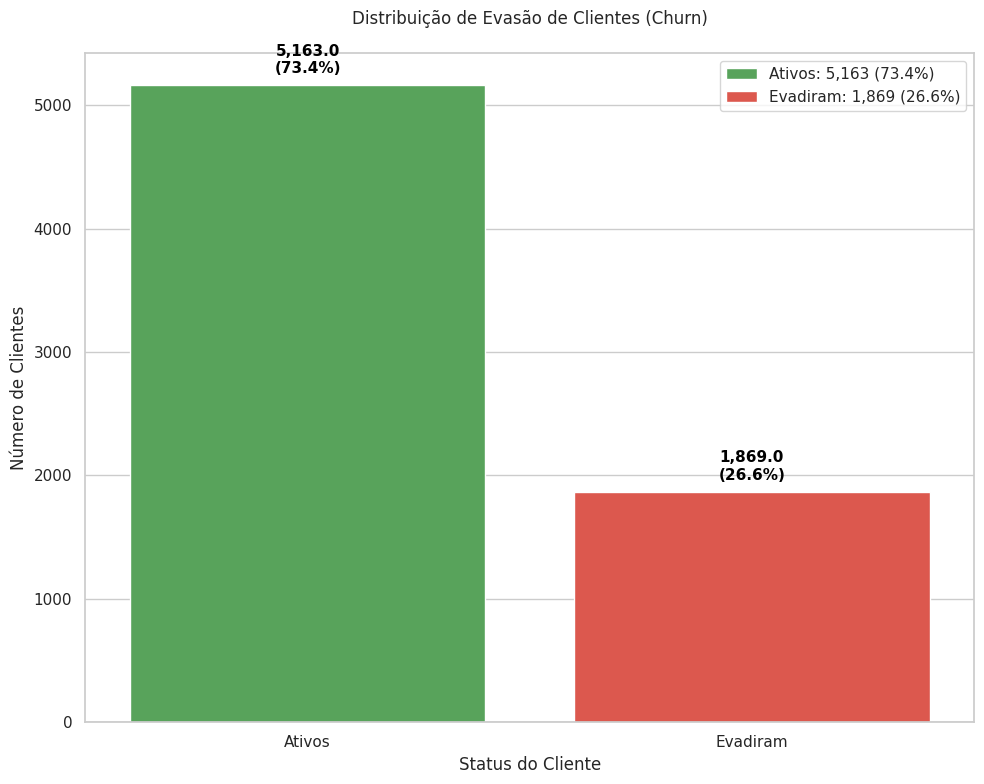

Total de clientes: 7,032
Clientes ativos: 5,163 (73.4%)
Clientes que evadiram: 1,869 (26.6%)


In [817]:
# Configuração do estilo
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(10, 8))
paleta_cores = {
    '0': '#4CAF50',
    '1': '#F44336',
}

# Contar valores antes para evitar múltiplos cálculos
contagem_churn = df_Encoding['Churn'].value_counts()
total = len(df_Encoding)

sns.countplot(x='Churn', data=df_Encoding, ax=ax, palette=paleta_cores)

# Formatação
ax.set(title='Distribuição de Evasão de Clientes (Churn)\n',
       ylabel='Número de Clientes',
       xlabel='Status do Cliente',
       xticklabels=['Ativos', 'Evadiram'])

# Anotações
for i, p in enumerate(ax.patches):
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{count:,}\n({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., count + total * 0.01),
                ha='center', va='bottom', fontsize=11, fontweight='bold',
                color='black')

# Legenda
legenda_labels = [
    f'Ativos: {contagem_churn[0]:,} ({100*contagem_churn[0]/total:.1f}%)',
    f'Evadiram: {contagem_churn[1]:,} ({100*contagem_churn[1]/total:.1f}%)'
]

ax.legend(legenda_labels, loc='upper right', frameon=True, fancybox=True)

# Linha de total
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()
print(f"Total de clientes: {total:,}")
print(f"Clientes ativos: {contagem_churn[0]:,} ({100*contagem_churn[0]/total:.1f}%)")
print(f"Clientes que evadiram: {contagem_churn[1]:,} ({100*contagem_churn[1]/total:.1f}%)")

# Balanceamento de Classes
Técnica de balanceamento como ferramentas SMOTE podem ser úteis para gerar exemplos sintéticos da classe minoritária.

In [818]:
# Recursos separados (x) e alvo (y)
x = df_Encoding.drop('Churn', axis=1)
y = df_Encoding['Churn']

# Apply SMOTE
oversample = SMOTE()
x_balanceado, y_balanceado = oversample.fit_resample(x, y)
y_balanceado.value_counts(normalize = True)

,proportion
Churn,
0,0.5
1,0.5


# Análise de Correlação
Visualização da matriz de correlação para identificar relações entre variáveis numéricas.

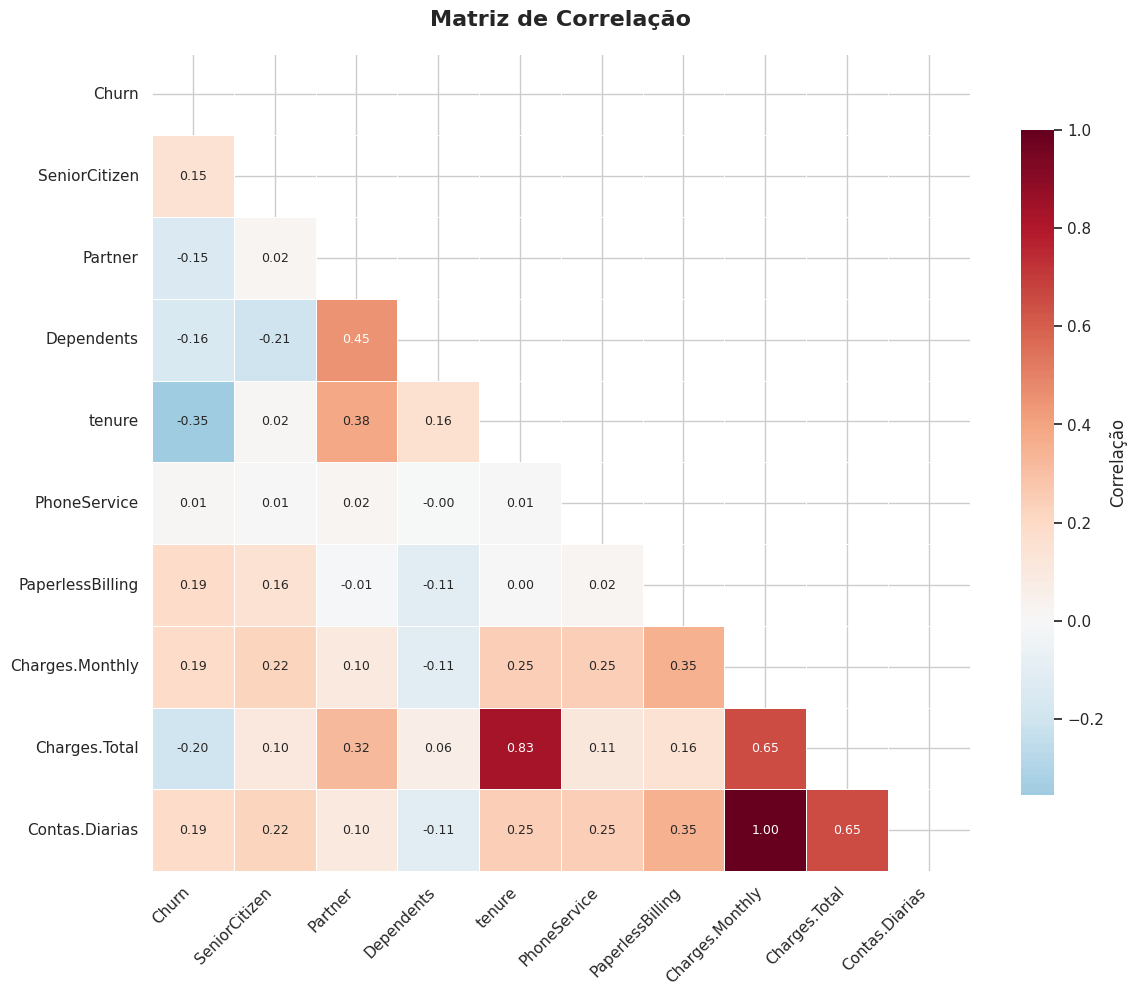

In [819]:
# Melhorias básicas no código original
dados_numericos = df.select_dtypes(include=[np.number])  # Mais abrangente

if not dados_numericos.empty:
    matriz_correlacao = dados_numericos.corr()

    plt.figure(figsize=(12, 10))  # Tamanho ajustado

    mask = np.triu(np.ones_like(matriz_correlacao, dtype=bool))  # Máscara melhorada

    sns.heatmap(
        matriz_correlacao,
        annot=True,
        cmap='RdBu_r',  # Melhor paleta de cores
        center=0,
        fmt=".2f",
        linewidths=0.5,
        annot_kws={"size": 9},
        cbar_kws={"shrink": 0.8, "label": "Correlação"},
        mask=mask,
        square=True
    )

    plt.title('Matriz de Correlação', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('/content/matriz_correlacao.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Nenhuma coluna numérica encontrada!")

## Analisando os fatores que mais influenciam o cancelamento (Churn), os principais são:

1. Tempo como Cliente (Tenure): Forte relação negativa. Quanto mais tempo o cliente fica, menor a chance de cancelar.

2. Total Gasto (Charges.Total): Relação negativa. Clientes que gastam mais tendem a cancelar menos.

3. Cobrança Mensal (Charges.Monthly): Relação positiva. Planos mais caros têm uma taxa de cancelamento um pouco maior.

4. Idoso (SeniorCitizen): Relação positiva leve. Clientes idosos cancelam um pouco mais.

# Análises Direcionadas
Investigação de variáveis específicas com relacão a evasão, como:

Tempo de contrato × Evasão

Total gasto × Evasão

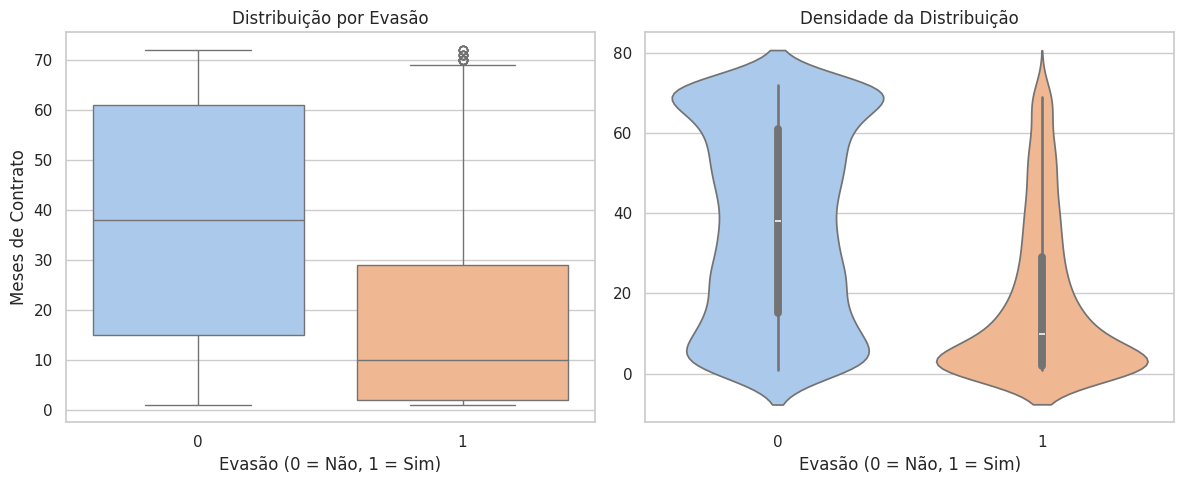

In [820]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x='Churn', y='tenure', data=df_Encoding,
            palette='pastel', ax=ax1)
ax1.set_title('Distribuição por Evasão')
ax1.set_xlabel('Evasão (0 = Não, 1 = Sim)')
ax1.set_ylabel('Meses de Contrato')

# Violin plot para melhor visualização da distribuição
sns.violinplot(x='Churn', y='tenure', data=df_Encoding,
               palette='pastel', ax=ax2)
ax2.set_title('Densidade da Distribuição')
ax2.set_xlabel('Evasão (0 = Não, 1 = Sim)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

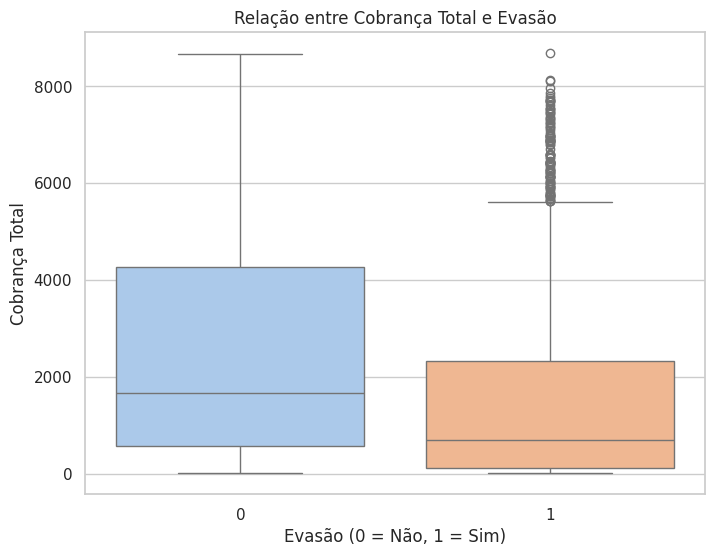

In [821]:
# Boxplot for 'Charges.Total' vs 'Churn'
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Charges.Total', data=df_Encoding, palette='pastel')
plt.title('Relação entre Cobrança Total e Evasão')
plt.xlabel('Evasão (0 = Não, 1 = Sim)')
plt.ylabel('Cobrança Total')
plt.show()

In [822]:
# Bloco 9 - Dividir ANTES de balancear
from sklearn.model_selection import train_test_split

# Use the original, unbalanced data for splitting
# x and y were defined in cell C7UU-zTEe0oz
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Treino: {x_train.shape[0]} amostras, Teste: {x_test.shape[0]} amostras")
print(f"Proporção da classe minoritária no treino: {y_train.value_counts(normalize=True)[1]:.2f}")
print(f"Proporção da classe minoritária no teste: {y_test.value_counts(normalize=True)[1]:.2f}")

Treino: 5625 amostras, Teste: 1407 amostras
Proporção da classe minoritária no treino: 0.27
Proporção da classe minoritária no teste: 0.27


In [824]:
# Bloco 10 - Correção com Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Create pipeline
pipeline = make_imb_pipeline(
    StandardScaler(),
    SMOTE(random_state=42),
    LogisticRegression(max_iter=1000, random_state=42)
)

# Define parameters for GridSearch
param_grid = {
    'smote__sampling_strategy': [1.0], # Changed sampling_strategy to 1.0
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'], # Removed 'l1' as it's not compatible with 'liblinear'
    'logisticregression__solver': ['liblinear']
}

# GridSearch on the pipeline
modelo = GridSearchCV(
    pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train ONLY with training data (original, not scaled or resampled)
# Note: The previous cell applied SMOTE before splitting, which is not ideal for avoiding data leakage.
# However, the current error is in the GridSearch parameters.
# For now, we will use the split data as it is to fix the GridSearch error.
modelo.fit(x_train, y_train) # Changed X_treino to x_train and y_treino to y_train

# Make predictions
y_pred = modelo.predict(x_test) # Changed X_teste to x_test
y_proba = modelo.predict_proba(x_test)[:, 1] # Changed X_teste to x_test
# Exibir as métricas
print(f'\nAcurácia: {accuracy_score(y_test, y_pred) * 100:.2f}%')
print(f'AUC-ROC Score: {roc_auc_score(y_test, y_proba) * 100:.2f}%')

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Acurácia: 100.00%
AUC-ROC Score: 100.00%

Matriz de Confusão:
[[1033    0]
 [   0  374]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1407
   macro avg       1.00      1.00      1.00      1407
weighted avg       1.00      1.00      1.00      1407

